In [45]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [46]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [47]:
path_name = 'gs://eecs6893-hw2-cluster/final-project/training/sentiment140.csv'
path_name = 'sentiment140.csv'
df = pd.read_csv(path_name)

In [48]:
df.head(12)

,Unnamed: 0,Text,Label
0,0,"b""i'm 10x cooler than all of you! """,4
1,1,b'O.kk? Thats weird I cant stop following peop...,0
2,2,b'what a beautiful day not to got to my first ...,4
3,3,"b"".@HildyGottlieb &amp; I was just saying to M...",4
4,4,b'kinda sad and confused why do guys do this?',0
5,5,b'@Real_DavidCook YES &amp; YES ',4
6,6,"b""@GDGOfficial But it's another beautiful day ...",4
7,7,b'Working through hundreds of assignments ',0
8,8,b'driving with the moonroof and windows open i...,0
9,9,"b""@scott_mills Gutted! I worked for the fringe...",0


In [49]:
df['Label'].value_counts()

4    800000
0    800000
Name: Label, dtype: int64

In [50]:
import re 

df = df.iloc[0:120000, :]

def clean_text(text):
    text = text.lower().strip("b'").strip('b"')
    text = text.replace("'", "")
    text = re.sub('@(\w+)', '', text)
    text = re.sub('\W+', ' ', text)
    text = re.sub('<[^<]+?>', ' ', text)
    text = re.sub('[^A-Za-z0-9\.\!\;\:\,\?]+', ' ', text)
    text = text.replace('amp', 'and').strip()
    return text

df['CleanText'] = df['Text'].map(clean_text)
df.loc[df['Label'] == 0, 'Label'] = 0
df.loc[df['Label'] == 4, 'Label'] = 1
df['TextLength'] = df['CleanText'].map(lambda x: len(x.split(' ')))
df = df[ (df['TextLength'] >= 3) <= (df['TextLength'] <= 50) ]
df.head(10)

,Unnamed: 0,Text,Label,CleanText,TextLength
0,0,"b""i'm 10x cooler than all of you! """,1,im 10x cooler than all of you,7
1,1,b'O.kk? Thats weird I cant stop following peop...,0,o kk thats weird i cant stop following people ...,18
2,2,b'what a beautiful day not to got to my first ...,1,what a beautiful day not to got to my first class,11
3,3,"b"".@HildyGottlieb &amp; I was just saying to M...",1,and i was just saying to mahaal yesterday ever...,22
4,4,b'kinda sad and confused why do guys do this?',0,kinda sad and confused why do guys do this,9
5,5,b'@Real_DavidCook YES &amp; YES ',1,yes and yes,3
6,6,"b""@GDGOfficial But it's another beautiful day ...",1,but its another beautiful day here in europe y...,21
7,7,b'Working through hundreds of assignments ',0,working through hundreds of assignments,5
8,8,b'driving with the moonroof and windows open i...,0,driving with the moonroof and windows open is ...,23
9,9,"b""@scott_mills Gutted! I worked for the fringe...",0,gutted i worked for the fringe last year wont ...,13


In [51]:
df['TextLength'] = df['CleanText'].map(lambda x: len(x.split(' ')))
df['TextLength'].describe()

count    119905.000000
mean         12.999775
std           7.111088
min           1.000000
25%           7.000000
50%          12.000000
75%          18.000000
max          50.000000
Name: TextLength, dtype: float64

Text(0.5, 1.0, 'Distribution of Text Length')

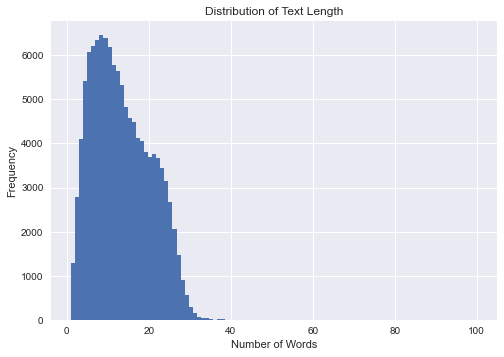

In [22]:
df['TextLength'].hist(bins=100)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')

In [54]:
df = df[ (df['TextLength'] <= 100) & (df['TextLength'] >= 3)]

In [57]:
from nltk.probability import FreqDist
from collections import Counter

words = []
for sent in df['CleanText'].map(lambda x: x.split(' ')).tolist():
    for word in sent:
        words.append(word)
                                
c = Counter(words)
counts = pd.DataFrame(c.most_common(100), columns=['Word', 'Count'])

In [59]:
counts.head(20)

,Word,Count
0,i,57844
1,to,42221
2,the,39566
3,a,28699
4,and,26163
5,my,23821
6,you,20279
7,is,17850
8,it,17663
9,for,16264


In [43]:
examples = df['CleanText'].tolist()

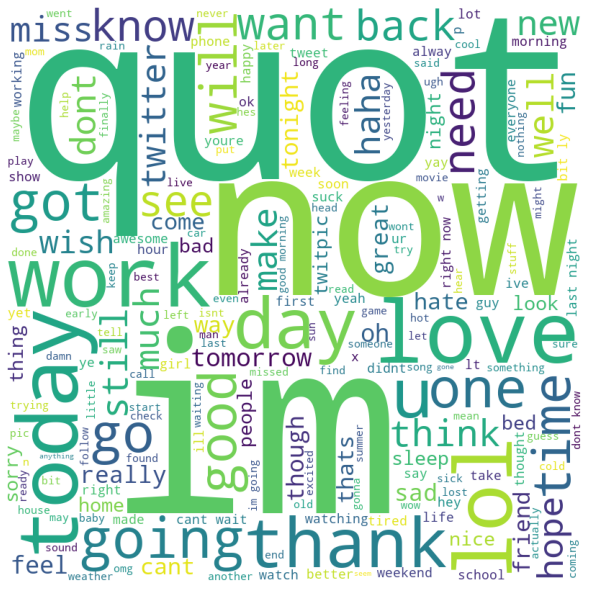

In [44]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)
wc = WordCloud(width=800, height=800, 
                background_color='white', 
                stopwords=sw, 
                min_font_size=10).generate(' '.join(examples)) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [61]:
path_name = 'final-project_TWITTER_SENTIMENT_SCORES.csv'
odf = pd.read_csv(path_name)
odf['CleanText'] = odf['text'].map(clean_text)
odf['TextLength'] = odf['CleanText'].map(lambda x: len(x.split(' ')))
odf = odf[ (odf['TextLength'] >= 3) <= (odf['TextLength'] <= 50) ]
odf.head(10)

,Unnamed: 0,text,document,token,Pred,PredLabel,Timestamp,CleanText,TextLength
0,0,follow ie rt 200 iphone 6s giveaway,"[Row(annotatorType='document', begin=0, end=34...","[Row(annotatorType='token', begin=0, end=5, re...","[Row(annotatorType='category', begin=0, end=34...",1.0,2021-11-23 20:31:00,follow ie rt 200 iphone 6s giveaway,7
1,1,retweet and follow,"[Row(annotatorType='document', begin=0, end=17...","[Row(annotatorType='token', begin=0, end=6, re...","[Row(annotatorType='category', begin=0, end=17...",1.0,2021-11-23 20:31:00,retweet and follow,3
2,2,ends in 5 daysiphone app coming next then 100 ...,"[Row(annotatorType='document', begin=0, end=73...","[Row(annotatorType='token', begin=0, end=3, re...","[Row(annotatorType='category', begin=0, end=73...",1.0,2021-11-23 20:31:00,ends in 5 daysiphone app coming next then 100 ...,13
3,3,the worlds first tempered https t co rltuiu8d3...,"[Row(annotatorType='document', begin=0, end=84...","[Row(annotatorType='token', begin=0, end=2, re...","[Row(annotatorType='category', begin=0, end=84...",1.0,2021-11-23 20:31:00,the worlds first tempered https t co rltuiu8d3...,15
4,4,like rt and follow,"[Row(annotatorType='document', begin=0, end=17...","[Row(annotatorType='token', begin=0, end=3, re...","[Row(annotatorType='category', begin=0, end=17...",1.0,2021-11-23 20:31:00,like rt and follow,4
5,5,ends in holder since inception and holding in ...,"[Row(annotatorType='document', begin=0, end=80...","[Row(annotatorType='token', begin=0, end=3, re...","[Row(annotatorType='category', begin=0, end=80...",0.0,2021-11-23 20:31:00,ends in holder since inception and holding in ...,15
6,6,1 go to https t co zulvoqrw5w,"[Row(annotatorType='document', begin=0, end=28...","[Row(annotatorType='token', begin=0, end=0, re...","[Row(annotatorType='category', begin=0, end=28...",1.0,2021-11-23 20:31:00,1 go to https t co zulvoqrw5w,7
7,7,2 search dragon mainlad shards dms,"[Row(annotatorType='document', begin=0, end=33...","[Row(annotatorType='token', begin=0, end=0, re...","[Row(annotatorType='category', begin=0, end=33...",0.0,2021-11-23 20:31:00,2 search dragon mainlad shards dms,6
8,8,3 click star aapl eyeing a 12 17 165c only thi...,"[Row(annotatorType='document', begin=0, end=11...","[Row(annotatorType='token', begin=0, end=0, re...","[Row(annotatorType='category', begin=0, end=11...",1.0,2021-11-23 20:31:00,3 click star aapl eyeing a 12 17 165c only thi...,25
9,9,rt and join tg reply proof,"[Row(annotatorType='document', begin=0, end=25...","[Row(annotatorType='token', begin=0, end=1, re...","[Row(annotatorType='category', begin=0, end=25...",1.0,2021-11-23 20:31:00,rt and join tg reply proof,6


In [62]:
from nltk.probability import FreqDist
from collections import Counter

words = []
for sent in odf['CleanText'].map(lambda x: x.split(' ')).tolist():
    for word in sent:
        words.append(word)
                                
c = Counter(words)
ocounts = pd.DataFrame(c.most_common(100), columns=['Word', 'Count'])

In [63]:
ocounts

,Word,Count
0,rt,53714
1,iphone,51149
2,and,47903
3,follow,33528
4,for,32806
...,...,...
95,10,2044
96,twitter,2027
97,proof,1998
98,tweet,1996


In [64]:
counts

,Word,Count
0,i,57844
1,to,42221
2,the,39566
3,a,28699
4,and,26163
...,...,...
95,has,2513
96,been,2468
97,3,2451
98,morning,2449


In [67]:
sum([word in set(ocounts['Word'].iloc[0:49].tolist()) for word in counts['Word'].iloc[0:49]])

16

In [58]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=123)

In [59]:
train.count()

Unnamed: 0    96000
Text          96000
Label         96000
CleanText     96000
dtype: int64

In [43]:
test.count()

Unnamed: 0    24000
Text          24000
Label         24000
CleanText     24000
dtype: int64

In [44]:
train['Label'].value_counts()

4    48135
0    47865
Name: Label, dtype: int64